In [1]:
# This notebook works with several simple datasets. For
# each it displays the rules and for several also 
# demonstrates predicting on the same data or using
# a train-test split.

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from prism_rules import PrismRules

## Example: Simple example with synthetic data

In [3]:
# Create 3 columns in X, and one Y column, where there columns in X each have 6
# unique values, and the Y column follows a simple rule with no exceptions. 
# This is an example with categorical values in the X columns. 

vals = [0, 1, 2, 3, 4, 5]
np.random.seed(42)
a_arr = np.random.choice(vals, 1000)
b_arr = np.random.choice(vals, 1000)
c_arr = np.random.choice(vals, 1000)
y = [True if ((a >= 2) and (b >= 1) and (c <= 4)) else False for a, b, c in zip(a_arr, b_arr, c_arr)]
df = pd.DataFrame({"a": a_arr, 
                   "b": b_arr, 
                   "c": c_arr, 
                   "Y": y})

prism = PrismRules()
_ = prism.get_prism_rules(df, 'Y')


........................................................................
Target: True
........................................................................
a = 2 AND c = 1
   Support:  the target has value: 'True' for 96.154% of the 25 rows matching the rule 
   Coverage: the rule matches: 25 out of 457 rows for target value: 'True'. This is:
      5.470% of total rows for target value: 'True'
      2.500% of total rows in data
a = 5 AND b = 1
   Support:  The target has value: 'True' for 96.296% of the 26 remaining rows matching the rule
   Coverage: The rule matches: 26 out of 432 rows remaining for target value: 'True'. This is:
      6.019% of remaining rows for target value: 'True'
      5.689% of total rows for target value: 'True'
      2.600% of total rows in data
a = 4 AND c = 2
   Support:  The target has value: 'True' for 89.474% of the 17 remaining rows matching the rule
   Coverage: The rule matches: 17 out of 406 rows remaining for target value: 'True'. This is:
     

In [4]:
# This tests predicting on the training data, so is simply a 
# smoke test and not a measure of how accurute the model is. 
# In this case, the synthetic data is perfectly consistent
# so any test data would be similar. 
# This sets average to None, to get the F1 score for both classes. 

y_pred = prism.predict(df.drop(columns=['Y']))
f1_score(df['Y'], y_pred, average=None)

array([0.87831656, 0.85336273])

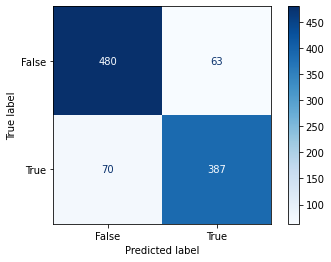

In [5]:
# We next display the confusion matrix. 

labels = y_pred.unique()
cm = confusion_matrix(df['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [6]:
# We again get the predictions, this time leaving any 
# records where the is no prediction as "NO PREDICTION"
# as opposed to using the default (most common) value.
# This is done setting leave_unknown to True.
# Here we must set the Y column to string to match the 
# type of the predictions. 

# The f1 score improves for the first class as less 
# predictions were made in error, though this does leave
# 70 records with no prediction, as seen next. 

y_pred = prism.predict(df.drop(columns=['Y']), leave_unknown=True)
f1_score(df['Y'].astype(str), y_pred, average=None)

array([0.93841642, 0.        , 0.85336273])

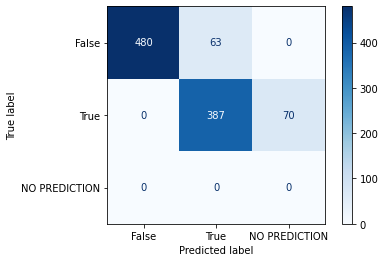

In [7]:
# We esnure the labels are in the same order as the previous
# confusion matrix to make comparing easier. We can see here
# that all records with no prediction are actually True. 

labels = labels.tolist() + ['NO PREDICTION']
cm = confusion_matrix(df['Y'].astype(str), y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

## Example: Using sklearn's make_classification

In [8]:
# This is an example with numeric values in the X columns. They will
# automatically be binned. This uses the default 3 bins per numeric
# feature, so will map the values to: Low, Med, and High.

bunch = make_classification(n_samples=1000, flip_y=0, random_state=0)
df = pd.DataFrame(bunch[0])
df['Y'] = bunch[1]

prism = PrismRules(min_coverage=100)
_ = prism.get_prism_rules(df, 'Y')


........................................................................
Target: 1
........................................................................
1 = High AND 16 = High
   Support:  the target has value: '1' for 100.000% of the 158 rows matching the rule 
   Coverage: the rule matches: 158 out of 500 rows for target value: '1'. This is:
      31.600% of total rows for target value: '1'
      15.800% of total rows in data
1 = High AND 16 = Med
   Support:  The target has value: '1' for 100.000% of the 117 remaining rows matching the rule
   Coverage: The rule matches: 117 out of 342 rows remaining for target value: '1'. This is:
      34.211% of remaining rows for target value: '1'
      23.400% of total rows for target value: '1'
      11.700% of total rows in data
4 = High
   Support:  The target has value: '1' for 81.343% of the 109 remaining rows matching the rule
   Coverage: The rule matches: 109 out of 225 rows remaining for target value: '1'. This is:
      48.444% of

In [9]:
y_pred = prism.predict(df.drop(columns=['Y']))
f1_score(df['Y'], y_pred, average=None)

array([0.86754967, 0.89031079])

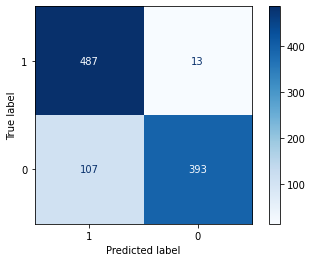

In [10]:
labels = y_pred.unique()
cm = confusion_matrix(df['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [11]:
# This is another example setting leave_unkown to True.

y_pred = prism.predict(df.drop(columns=['Y']), leave_unknown=True)
y_pred = y_pred.map({"0.0": "0", "1.0": "1", "NO PREDICTION": "NO PREDICTION"})
f1_score(df['Y'].astype(str), y_pred.astype(str), average=None)

array([0.86754967, 0.84140969, 0.        ])

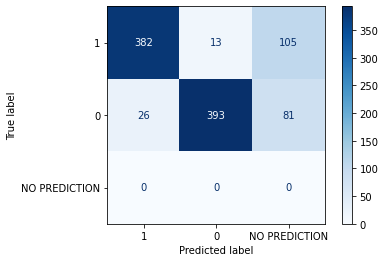

In [12]:
# In this case, a signficicant number of records received no 
# prediction, though the majority did. We may wish to adjust
# the parameters for min_support and min_confidence to 
# generate more predicitons, or, as by default, set the 
# records matching no rules to the most common value in the
# target column. 

labels = labels.tolist() + ['NO PREDICTION']
cm = confusion_matrix(df['Y'].astype(str), y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

## Example: Using sklearn's make_blobs

In [13]:
bunch = make_blobs(
    n_samples=1000, 
    n_features=20,    
    centers=2,  # Generate 2 blobs
    random_state=0
    )

df = pd.DataFrame(bunch[0])
df['Y'] = bunch[1]

prism = PrismRules()
_ = prism.get_prism_rules(df, 'Y')


........................................................................
Target: 0
........................................................................
0 = Low
   Support:  the target has value: '0' for 100.000% of the 334 rows matching the rule 
   Coverage: the rule matches: 334 out of 500 rows for target value: '0'. This is:
      66.800% of total rows for target value: '0'
      33.400% of total rows in data
19 = High
   Support:  The target has value: '0' for 100.000% of the 114 remaining rows matching the rule
   Coverage: The rule matches: 114 out of 166 rows remaining for target value: '0'. This is:
      68.675% of remaining rows for target value: '0'
      22.800% of total rows for target value: '0'
      11.400% of total rows in data
17 = High
   Support:  The target has value: '0' for 100.000% of the 38 remaining rows matching the rule
   Coverage: The rule matches: 38 out of 52 rows remaining for target value: '0'. This is:
      73.077% of remaining rows for target v

In [14]:
y_pred = prism.predict(df.drop(columns=['Y']))
f1_score(df['Y'], y_pred)

0.9888776541961577

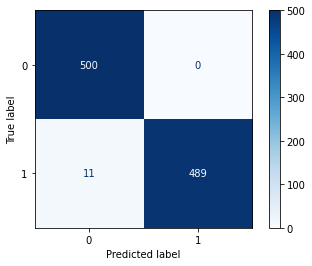

In [15]:
labels = y_pred.unique()
cm = confusion_matrix(df['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [16]:
# Again, an example allowing for NO PREDICTION. 

y_pred = prism.predict(df.drop(columns=['Y']), leave_unknown=True)
y_pred = y_pred.map({"0.0": "0", "1.0": "1", "NO PREDICTION": "NO PREDICTION"})
f1_score(df['Y'].astype(str), y_pred.astype(str), average=None)

array([0.99799599, 0.98887765, 0.        ])

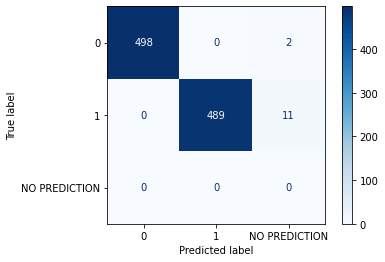

In [17]:
labels = labels.tolist() + ['NO PREDICTION']
cm = confusion_matrix(df['Y'].astype(str), y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

## Example: Using the Iris dataset

In [18]:
# This uses a real (though toy) dataset. To evaluate fully,
# we would use cross validation, but for simplicity use a train-test
# split here. We use 100 rows for training and 50 for test

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Y'] = data['target']
display(df.head())
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

prism = PrismRules()
_ = prism.get_prism_rules(df.head(100), 'Y')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Number of rows: 150

........................................................................
Target: 1
........................................................................
petal length (cm) = Med AND petal width (cm) = Med
   Support:  the target has value: '1' for 100.000% of the 30 rows matching the rule 
   Coverage: the rule matches: 30 out of 32 rows for target value: '1'. This is:
      93.750% of total rows for target value: '1'
      30.000% of total rows in data

........................................................................
Target: 0
........................................................................
petal length (cm) = Low
   Support:  the target has value: '0' for 100.000% of the 34 rows matching the rule 
   Coverage: the rule matches: 34 out of 34 rows for target value: '0'. This is:
      100.000% of total rows for target value: '0'
      34.000% of total rows in data

........................................................................
Target: 2


In [19]:
y_pred = prism.predict(df.tail(50).drop(columns=['Y']))
f1_score(df.tail(50)['Y'], y_pred, average=None)

array([0.81081081, 0.77419355, 0.875     ])

In [20]:
confusion_matrix(df.tail(50)['Y'], y_pred)

array([[15,  1,  0],
       [ 4, 12,  2],
       [ 2,  0, 14]], dtype=int64)

## Example: Using the Wine dataset

In [21]:
data = datasets.load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Y'] = data['target']
display(df.head())
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

prism = PrismRules()
_ = prism.get_prism_rules(df.head(140), 'Y')

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Number of rows: 178

........................................................................
Target: 1
........................................................................
color_intensity = Low AND alcohol = Low
   Support:  the target has value: '1' for 100.000% of the 37 rows matching the rule 
   Coverage: the rule matches: 37 out of 56 rows for target value: '1'. This is:
      66.071% of total rows for target value: '1'
      26.429% of total rows in data
proline = Low AND malic_acid = Low
   Support:  The target has value: '1' for 100.000% of the 10 remaining rows matching the rule
   Coverage: The rule matches: 10 out of 19 rows remaining for target value: '1'. This is:
      52.632% of remaining rows for target value: '1'
      17.857% of total rows for target value: '1'
      7.143% of total rows in data

........................................................................
Target: 0
........................................................................
proline = Hig

In [22]:
y_pred = prism.predict(df.tail(38).drop(columns=['Y']))
f1_score(df.tail(38)['Y'], y_pred, average=None)

array([0.72727273, 0.77777778, 0.88888889])

In [23]:
confusion_matrix(df.tail(38)['Y'], y_pred)

array([[ 8,  5,  0],
       [ 1, 14,  0],
       [ 0,  2,  8]], dtype=int64)

## Examples from openml

In [24]:
def test_openml_dataset(dataset_name):
    data = fetch_openml(dataset_name, parser='auto', version=1)
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['Y'] = data.target
    display(df.head())
    df = df.sample(n=len(df))
    
    prism = PrismRules(min_coverage=100, verbose=1)
    _ = prism.get_prism_rules(df, 'Y')    

In [25]:
# This finds rules for only one class, which can be a biproduct of some classes
# being much more frequent than other classes, and is not typically a useful
# set of rules, though can provide some insights into the data. 

test_openml_dataset("hypothyroid")

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Y
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


Determining rules for each of 4 target classes:
Determining rules for target class: negative
  Determining next rule. 3,481 rows remaining for target class
  Determining next rule. 2,371 rows remaining for target class
  Determining next rule. 2,002 rows remaining for target class
  Determining next rule. 873 rows remaining for target class
  Determining next rule. 770 rows remaining for target class
  Determining next rule. 659 rows remaining for target class
  Determining next rule. 559 rows remaining for target class
  Determining next rule. 441 rows remaining for target class
  Determining next rule. 341 rows remaining for target class
Determining rules for target class: compensated_hypothyroid
  Determining next rule. 194 rows remaining for target class
Determining rules for target class: primary_hypothyroid
Determining rules for target class: secondary_hypothyroid

........................................................................
Target: negative
..........................

In [26]:
# In this example, we adjust the min_coverage parameter

data = fetch_openml("CreditCardSubset", parser='auto')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Y'] = data.target
display(df.head())

prism = PrismRules(min_coverage=5, verbose=0)
_ = prism.get_prism_rules(df, 'Y') 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Y
0,160466,-2.248971,-1.982501,-1.285486,-2.092348,1.512952,-2.149212,0.398840,0.009753,-1.278035,...,0.217312,0.100500,-0.407628,0.536201,1.470398,0.480210,-0.141845,-0.358375,145.80,0
1,117596,2.061359,-0.047083,-1.060125,0.418250,-0.144300,-1.217912,0.188331,-0.338308,0.533794,...,-0.288030,-0.693703,0.340591,0.047605,-0.298054,0.195206,-0.070450,-0.059714,1.98,0
2,29633,-0.697894,1.010449,1.575473,1.779442,-0.212302,-0.227076,0.554638,-0.155702,-0.255471,...,-0.055732,-0.069504,-0.289604,0.390298,0.456975,-0.089808,-0.371611,0.068766,32.38,0
3,41416,0.271994,-2.737118,0.114183,-0.090708,-1.750009,0.424753,-0.381162,-0.018583,0.186178,...,0.290923,-0.335537,-0.627308,-0.523477,0.284506,-0.246078,-0.060874,0.117236,598.52,0
4,47454,-1.176577,-1.172877,1.432388,-1.431982,-0.056468,-0.517569,0.184114,0.114787,-0.688048,...,0.261313,0.516481,0.253206,0.180029,0.008194,-0.346822,0.106330,-0.034765,142.90,0



........................................................................
Target: 0
........................................................................
V4 = Low
   Support:  the target has value: '0' for 100.000% of the 4747 rows matching the rule 
   Coverage: the rule matches: 4747 out of 14217 rows for target value: '0'. This is:
      33.390% of total rows for target value: '0'
      33.336% of total rows in data
V10 = Med
   Support:  The target has value: '0' for 100.000% of the 3902 remaining rows matching the rule
   Coverage: The rule matches: 3902 out of 9470 rows remaining for target value: '0'. This is:
      41.204% of remaining rows for target value: '0'
      27.446% of total rows for target value: '0'
      27.402% of total rows in data
V12 = Med
   Support:  The target has value: '0' for 100.000% of the 1906 remaining rows matching the rule
   Coverage: The rule matches: 1906 out of 5568 rows remaining for target value: '0'. This is:
      34.231% of remaining row

In [27]:
test_openml_dataset("cardiotocography")

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V27,V28,V29,V30,V31,V32,V33,V34,V35,Y
0,23,240,357,120,120,0,0,0,73,0.5,...,0,0,0,0,0,0,0,1,0,9
1,45,5,632,132,132,4,0,4,17,2.1,...,0,0,0,0,1,0,0,0,0,6
2,45,177,779,133,133,2,0,5,16,2.1,...,0,0,0,0,1,0,0,0,0,6
3,45,411,1192,134,134,2,0,6,16,2.4,...,0,0,0,0,1,0,0,0,0,6
4,45,533,1147,132,132,4,0,5,16,2.4,...,1,0,0,0,0,0,0,0,0,2


Determining rules for each of 10 target classes:
Determining rules for target class: 7
  Determining next rule. 252 rows remaining for target class
Determining rules for target class: 10
  Determining next rule. 197 rows remaining for target class
Determining rules for target class: 6
  Determining next rule. 332 rows remaining for target class
Determining rules for target class: 2
  Determining next rule. 579 rows remaining for target class
Determining rules for target class: 8
  Determining next rule. 107 rows remaining for target class
Determining rules for target class: 1
  Determining next rule. 384 rows remaining for target class
Determining rules for target class: 4
Determining rules for target class: 9
Determining rules for target class: 5
Determining rules for target class: 3

........................................................................
Target: 7
........................................................................
V32 = 1
   Support:  the target has value: '7' 

## Example: Using a dataset described in Principles of Data Mining

In [28]:
# See the github page for references. This dataset, lens24, was presented p.163.

df = pd.DataFrame(
    {
        "age":    [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3],
        "specRX": [1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2],
        "astig":  [1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2],
        "tears":  [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
        "class":  [3, 2, 3, 1, 3, 2, 3, 1, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3]
    }
)

# As this dataset has few rows, we set min_coverage lower than the default 10.
prism = PrismRules(min_coverage=2)
_ = prism.get_prism_rules(df, 'class')


........................................................................
Target: 3
........................................................................
tears = 1
   Support:  the target has value: '3' for 100.000% of the 12 rows matching the rule 
   Coverage: the rule matches: 12 out of 15 rows for target value: '3'. This is:
      80.000% of total rows for target value: '3'
      50.000% of total rows in data

........................................................................
Target: 2
........................................................................
astig = 1 AND tears = 2 AND specRX = 2
   Support:  the target has value: '2' for 100.000% of the 3 rows matching the rule 
   Coverage: the rule matches: 3 out of 5 rows for target value: '2'. This is:
      60.000% of total rows for target value: '2'
      12.500% of total rows in data

........................................................................
Target: 1
..................................................